# Noise reduction
- Noise reduction is typically the process of estimating and removing/reducing noise in a time series or spectrum.
    - Measured wind speed: Average wind (over a suitably small time interval) may be more interesting than every little whirl and change.
    - Master thesis on nuclear reactor cracks: 15 second resoultion gives uninteresting variations in the signal.
    - Instruments have a limit to their certified sensitivity: Smoothing sub-sensitivity can make sense.
- [scipy.signal](https://docs.scipy.org/doc/scipy/reference/signal.html) has a wide range of possibilites.
- At this stage the general assumption is that noise is uninformative, thus can be removed without harming the signal.
- Signal-to-noise is a ratio that can be caulculated in various ways.
    - A measure of how easy it is to extract the underlying information.

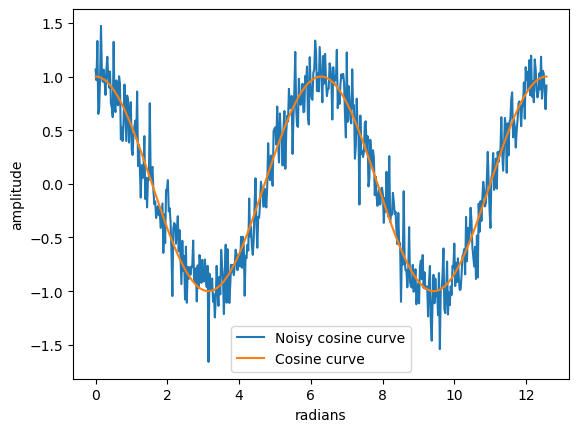

In [1]:
# Plot a cosine curve from 0 to 3pi
import matplotlib.pyplot as plt
import numpy as np
x = np.linspace(0, 4*np.pi, 500)
y = np.cos(x)

# Add noise to the curve
noise = 0.2*np.random.normal(size=(len(x)))
plt.plot(x, y+noise, label='Noisy cosine curve')
plt.plot(x, y, label='Cosine curve')
plt.xlabel('radians')
plt.ylabel('amplitude')
plt.legend()
plt.show()

## Moving average
- A window of length _n_ slides along the measured values.
    - Compute the average value of the window
    - Replace the central value.
- One of the simplest approaches available.
- Useable on streaming data:
    - No learning, lag equal to window width.
- Can be tuned:
    - Width of the window.
    - Weighted average, e.g., more weight on the central values.
    - Median instead of mean.
    - Replace the last value instead of the middle value (maybe using different weights).

### Simple moving average
An efficient alterantive can be found in the [Uniform 1D filter from SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.uniform_filter1d.html).
- Handles edge effects - which values to where the window doesn't fit?
- Can set which value to replace.

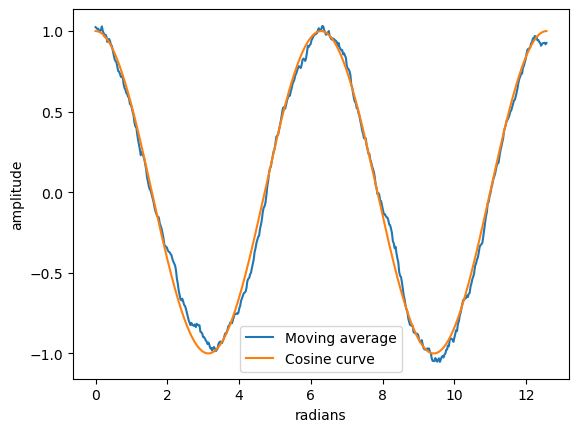

In [2]:
# Apply a simple moving average filter using uniform_filter1d
from scipy.ndimage import uniform_filter1d
y_sma = uniform_filter1d(y+noise, size=20) # Note that 'size' refers to number of values, not x-axis units
plt.plot(x, y_sma, label='Moving average')
plt.plot(x, y, label='Cosine curve')
plt.xlabel('radians')
plt.ylabel('amplitude')
plt.legend()
plt.show()

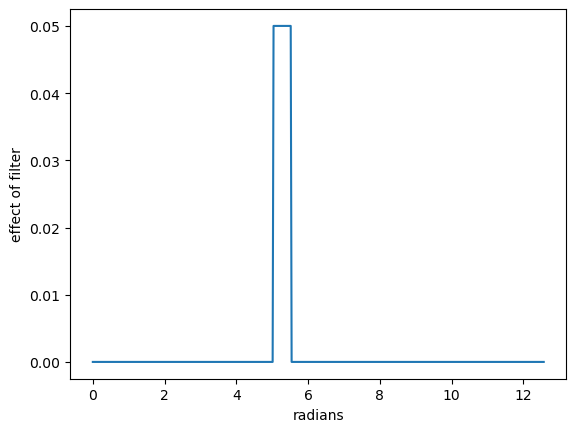

In [3]:
# The filter affects only locally
x = np.linspace(0, 4*np.pi, 500)
y = np.zeros(len(x))
y[200:220] = 1/20 # Filter of width 20 at position 210
plt.plot(x, y)
plt.xlabel('radians')
plt.ylabel('effect of filter')
plt.rcParams['figure.figsize'] = [5, 4]
plt.show()

In [4]:
# Use ipywidgets to interactively change the size of the filter
from ipywidgets import interact
def plot_sma(size):
    y_sma = uniform_filter1d(y+noise, size=size)
    plt.plot(x, y_sma, label='Moving average')
    plt.plot(x, y, label='Cosine curve')
    plt.xlabel('radians')
    plt.ylabel('amplitude')
    plt.legend()
    plt.show()
interact(plot_sma, size=(1, 100, 1))


interactive(children=(IntSlider(value=50, description='size', min=1), Output()), _dom_classes=('widget-interac…

<function __main__.plot_sma(size)>

### Exercise
1. Modify the interactive code to include choice of edge effect handling.
2. Modify further to choose between first, middle and last point in the window for origin (replaced value).

### Gaussian weighting
- Use a normal distribution to weight the interval.
- [SciPy's Gaussian 1D filter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter1d.html#scipy.ndimage.gaussian_filter1d) has several parameters (in addition to edge mode), but most important is:
    - _sigma_: the standard deviation of the kernel.
- SciPy's default is to cut the filter at +/- 4\*sigma

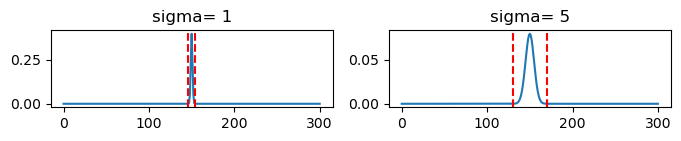

In [5]:
import numpy as np
import matplotlib.pyplot as plt

sigma1 = 1
sigma2 = 5

def gaussian(size,sigma):
    filter_range = np.linspace(-int(size/2),int(size/2),size)
    # The normal distribution in 1D
    gaussian_filter = [1 / (sigma * np.sqrt(2*np.pi)) * np.exp(-x**2/(2*sigma**2)) for x in filter_range]
    return gaussian_filter

# Plot the filters
fig,ax = plt.subplots(1,2)
fig.set_size_inches(8, 1)
ax[0].plot(gaussian(size=301,sigma=sigma1))
ax[0].axvline(x=150-4*sigma1, color='r', linestyle='--')
ax[0].axvline(x=150+4*sigma1, color='r', linestyle='--')
ax[0].set_title(f'sigma= {sigma1}')
ax[1].plot(gaussian(size=301,sigma=sigma2))
ax[1].axvline(x=150-4*sigma2, color='r', linestyle='--')
ax[1].axvline(x=150+4*sigma2, color='r', linestyle='--')
ax[1].set_title(f'sigma= {sigma2}')
plt.show()

In [6]:
from scipy.ndimage import gaussian_filter1d
# New data for a change
rng = np.random.default_rng(0)
y = rng.standard_normal(301).cumsum()

def plot_gauss(sigma, show_window, position):
    y_gauss = gaussian_filter1d(y, sigma=sigma)
    plt.plot(y, label='Random curve')
    plt.plot(y_gauss, label='Gaussian filtered curve')
    if show_window:
        plt.axvspan(position-round(4*sigma), position+round(4*sigma), color='red', alpha=0.2, label='Filter window')
    plt.xlabel('arbitrary units')
    plt.ylabel('amplitude')
    plt.legend()
    plt.show()
interact(plot_gauss, sigma=(0.1, 10, 0.1), show_window=True, position=(30, 270, 1))

interactive(children=(FloatSlider(value=5.0, description='sigma', max=10.0, min=0.1), Checkbox(value=True, des…

<function __main__.plot_gauss(sigma, show_window, position)>

In [7]:
# Savitsky-Golay filter
from scipy.signal import savgol_filter
yhat = savgol_filter(y+noise, 51, 3) # window size 51, polynomial order 3

ValueError: operands could not be broadcast together with shapes (301,) (500,) 

In [79]:
import ipywidgets as w
from IPython.display import display
a = w.IntSlider()
b = w.IntText()
display(a, b)
w.jslink((a, 'value'), (b, 'value'))

IntSlider(value=0)

IntText(value=0)

Link(source=(IntSlider(value=0), 'value'), target=(IntText(value=0), 'value'))

In [81]:
w.IntSlider() 

IntSlider(value=0)